#### Sanity checks on demand data
* Compare total demand per state to EIA total energy retail costs (currently done by Excel)
* Check missing data - output details for later checking
* For each bus, check that total rating of transmission lines coming out can satisfy demand for that bus

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.parser import parse

import seaborn as sns
sns.set()

%matplotlib inline


In [2]:
#Data directories
popdir = 'C:\\Users\\mlamherr\\Data'
savedir = 'C:\\Users\\mlamherr\\Data'
weccdir = 'U:\\RenewableEnergy\\EnergyGridModeling\\Data\\demand data for WECC\\WECC_demand_2016'

In [3]:
ba2016 = pd.read_csv(weccdir + "/" + 'BA_2016.csv', index_col='UTC Time', parse_dates =True )

In [4]:
#Bus areas 1-16 in numerical order as case10K file
WA = ['AVA', 'BPAT','CHPD','DOPD','GCPD','PSEI','SCL','TPWR','AVA', 'BPAT']
OR = ['BPAT','GRID','IPCO','PACW','PGE']
CAnorth = ['BANC','CISO','PACW','BPAT']
CABayArea = ['CISO']
CAcentral = ['CISO', 'TIDC']
CAsw = ['CISO', 'LDWP']
CAse = ['CISO', 'IID']
NV = ['NEVP']
AZ = ['AZPS','DEAA','GRIF','GRMA','HGMA','PNM','SRP','TEPC','WALC']
UT = ['PACE']
NM = ['EPE','PNM']
CO = ['PSCO','WACM']
WY = ['PACE','WACM']
ID = ['AVA','BPAT','IPCO','PACE']
MT = ['BPAT','GWA','NWMT','WAUW','WWA'] 
ElPaso = ['EPE']

BA_all = sorted(list(set().union(WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso)))

In [5]:
Northern_California = ['Butte','Colusa','Del Norte','El Dorado','Glenn','Humboldt',
                       'Lake','Lassen','Mendocino','Modoc','Nevada','Placer','Plumas',
                       'Sacramento','Shasta','Sierra','Siskiyou','Sutter','Tehama',
                       'Trinity','Yolo','Yuba']
Bay_Area = ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo',
            'Santa Clara','Santa Cruz','Solano','Sonoma']
Central_California = ['Alpine','Amador','Calaveras','Fresno','Inyo','Kings','Madera',
                      'Mariposa','Merced','Mono','Monterey','San Benito','San Joaquin',
                      'Stanislaus','Tulare','Tuolumne']
Southeast_California = ['Imperial','Orange','Riverside','San Bernardino','San Diego']
Southwest_California = ['Kern','Los Angeles','San Luis Obispo','Santa Barbara','Ventura']

CA = [Northern_California, Bay_Area, Central_California, Southeast_California, Southwest_California]
CAnames = ['Northern_California', 'Bay_Area', 'Central_California', 'Southeast_California', 'Southwest_California']
CA_all = Northern_California + Bay_Area + Central_California + Southeast_California +Southwest_California
CA_union = list(set().union(Northern_California, Bay_Area, Central_California, Southeast_California, Southwest_California))
shortCAnames = ['CAnorth','CABayArea','CAcentral','CAsw','CAse']

numCounties = 0
for x in zip(CAnames,CA):
    print('There are '+ str(len(x[1])) + ' counties in region ' + x[0])
    numCounties = numCounties + len(x[1])
print('There are ' + str(numCounties) + ' total counties in California.')


There are 22 counties in region Northern_California
There are 10 counties in region Bay_Area
There are 16 counties in region Central_California
There are 5 counties in region Southeast_California
There are 5 counties in region Southwest_California
There are 58 total counties in California.


In [6]:
# CA regions: get populations of demand regions

CA_population_file = 'Web_ACS2016_Pop-Race.xlsx'
df = pd.read_excel(io = weccdir + "/" + CA_population_file, sheet_name='Total Pop & Median Age', skiprows=[0,1,2,3,4])


In [7]:
df.head()

,Geography,Estimate,Margin of Error,Estimate.1,Margin of Error.1,Unnamed: 5,Summary Level,County,Place
0,California,39250017,*****,36.4,0.2,NaN,40,NaN,NaN
1,Alameda County,1647704,*****,37.4,0.2,NaN,50,1.0,NaN
2,Alameda city,78907,29,42.2,2.1,NaN,160,1.0,562.0
3,Berkeley city,121241,34,32.1,1.6,NaN,160,1.0,6000.0
4,Castro Valley CDP,65153,4863,43.1,2.9,NaN,160,1.0,11964.0


In [8]:
df.columns

Index(['Geography', 'Estimate', 'Margin of Error', 'Estimate.1',
       'Margin of Error.1', 'Unnamed: 5', 'Summary Level', 'County', 'Place'],
      dtype='object')

In [9]:
df.drop(columns =['Margin of Error', 'Estimate.1',
       'Margin of Error.1', 'Unnamed: 5', 'Summary Level', 'County', 'Place'], inplace=True)

In [10]:
df.head()

,Geography,Estimate
0,California,39250017
1,Alameda County,1647704
2,Alameda city,78907
3,Berkeley city,121241
4,Castro Valley CDP,65153


In [11]:
counties = df.loc[df['Geography'].str.contains('County')][['Geography','Estimate']]
counties = counties.reset_index(drop=True)

In [12]:
counties['Geography'] = counties['Geography'].str.replace(' County','')
counties.head()

,Geography,Estimate
0,Alameda,1647704
1,Butte,226864
2,Contra Costa,1135127
3,El Dorado,185625
4,Fresno,979915


Some counties do not have population data (from this source) because they have less than 65000 residents. There are total of 58 counties but only 40 have >65000 in 2016.

In [13]:
intersection = set(counties['Geography']) & set(pd.Series(CA_union))
union = set(counties['Geography']) | set(pd.Series(CA_union))
print('These 18 counties in CA have no population data')
print(set(union - intersection))  ## counties with < 65000 in 2016
print()
print('Counties with missing population data are in Northern and Central CA. ')

These 18 counties in CA have no population data
{'Mono', 'Calaveras', 'Amador', 'Del Norte', 'San Benito', 'Alpine', 'Sierra', 'Colusa', 'Tehama', 'Plumas', 'Tuolumne', 'Siskiyou', 'Modoc', 'Trinity', 'Glenn', 'Mariposa', 'Inyo', 'Lassen'}

Counties with missing population data are in Northern and Central CA. 


In [14]:
#Dictionary for region population counts
popcount = {}
for i in zip(shortCAnames, CA):
    region_name = i[0]
    region_county_list = i[1]
    popcount[region_name] = counties[counties['Geography'].isin(region_county_list)]['Estimate'].sum()
  

In [15]:
popcount

{'CAnorth': 3262336,
 'CABayArea': 7958684,
 'CAcentral': 3724007,
 'CAsw': 11199001,
 'CAse': 12601498}

In [16]:
#Add other population data cut and paste from the sources mentioned above.
#To do: The US Census data is automatable; not about El Paso yet
popcount['WA']=7280934
popcount['OR']=4085989
popcount['NV']=2939254
popcount['AZ']=6908642
popcount['UT']=3044321
popcount['NM']=2085432
popcount['CO']=5530105
popcount['WY']=584910
popcount['ID']=1680026
popcount['MT']=1038656
popcount['ElPaso']=678058

In [17]:
popcount

{'CAnorth': 3262336,
 'CABayArea': 7958684,
 'CAcentral': 3724007,
 'CAsw': 11199001,
 'CAse': 12601498,
 'WA': 7280934,
 'OR': 4085989,
 'NV': 2939254,
 'AZ': 6908642,
 'UT': 3044321,
 'NM': 2085432,
 'CO': 5530105,
 'WY': 584910,
 'ID': 1680026,
 'MT': 1038656,
 'ElPaso': 678058}

In [18]:
ba2016.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='UTC Time', length=8784, freq=None)

In [19]:
ba2016.head()

,AVA,AZPS,BANC,BPAT,CHPD,CISO,DEAA,DOPD,EPE,GCPD,...,PSEI,SCL,SRP,TEPC,TIDC,TPWR,WACM,WALC,WAUW,WWA
UTC Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1789.0,2982.0,1909.0,7689.0,325.0,23745.0,NaN,256.0,848.0,540.0,...,4238.0,1411.0,2730.0,1624.0,245.0,732.0,3254.0,838.0,108.0,NaN
2016-01-01 01:00:00,1930.0,3363.0,2028.0,8143.0,353.0,24213.0,NaN,282.0,948.0,573.0,...,4712.0,1488.0,3026.0,1801.0,256.0,784.0,3472.0,904.0,123.0,NaN
2016-01-01 02:00:00,1991.0,3642.0,2271.0,8634.0,371.0,25174.0,NaN,298.0,988.0,592.0,...,5085.0,1588.0,3262.0,1788.0,284.0,839.0,3448.0,948.0,110.0,NaN
2016-01-01 03:00:00,1970.0,3615.0,2301.0,8598.0,366.0,28423.0,NaN,293.0,959.0,594.0,...,5030.0,1551.0,3220.0,1763.0,285.0,837.0,3417.0,937.0,115.0,NaN
2016-01-01 04:00:00,1905.0,3568.0,2242.0,8390.0,365.0,28784.0,NaN,294.0,929.0,593.0,...,4845.0,1484.0,3142.0,1739.0,276.0,816.0,3374.0,922.0,112.0,NaN


Some BAs don't have any data for 2016. -- Check with EIA.

In [20]:
ba2016.isnull().sum()

AVA        0
AZPS       0
BANC       0
BPAT       0
CHPD       0
CISO       0
DEAA    8784
DOPD      16
EPE        0
GCPD       0
GRID    8784
GRIF    8784
GRMA    8784
GWA     8784
HGMA    8784
IID        0
IPCO       0
LDWP       0
NEVP       0
NWMT       0
PACE       0
PACW       0
PGE        0
PNM        0
PSCO       0
PSEI       0
SCL        0
SRP        0
TEPC       0
TIDC       0
TPWR       0
WACM       0
WALC       0
WAUW      24
WWA     8784
dtype: int64

EIA already imputes data up to 24 hours, i.e., if there is more than 24 consecutive hours of missing data, it does not impute beyond the first 24 points.

In [21]:
#Replace NA with 0's
ba2016.fillna(0, inplace=True)
ba2016.isnull().sum()

AVA     0
AZPS    0
BANC    0
BPAT    0
CHPD    0
CISO    0
DEAA    0
DOPD    0
EPE     0
GCPD    0
GRID    0
GRIF    0
GRMA    0
GWA     0
HGMA    0
IID     0
IPCO    0
LDWP    0
NEVP    0
NWMT    0
PACE    0
PACW    0
PGE     0
PNM     0
PSCO    0
PSEI    0
SCL     0
SRP     0
TEPC    0
TIDC    0
TPWR    0
WACM    0
WALC    0
WAUW    0
WWA     0
dtype: int64

In [22]:
#Shared BAs
totalCISO = popcount['CAnorth'] + popcount['CABayArea'] + popcount['CAcentral'] + popcount['CAsw'] + popcount['CAse']
totalBPAT = popcount['WA'] + popcount['OR'] + popcount['CAnorth'] + popcount['ID'] + popcount['MT']
totalAVA = popcount['ID']+popcount['WA']
totalPACW = popcount['OR']+popcount['CAnorth']
totalIPCO = popcount['OR']+popcount['ID']
totalPNM =  popcount['AZ']+popcount['NM']
totalPACE = popcount['UT']+popcount['WY']+popcount['ID']
totalEPE = popcount['ElPaso']+popcount['NM']
totalWACM = popcount['WY']+popcount['CO']

In [23]:
# Define region BA demand counts. 
# If a BA is entirely in region, give  all of that BA's count to the region
# If a BA is shared with other regions. get the fraction corresponding to the population fraction for that region
# BA sharing is found in Balancing_Authorities_JAN2017.pdf

#In region order:
ba2016['WA'] = ba2016['SCL'] + ba2016['PSEI'] + ba2016['TPWR'] + ba2016['CHPD'] + ba2016['DOPD'] + ba2016['GCPD'] + \
                ba2016['AVA']*popcount['WA']/totalAVA + ba2016['BPAT']*popcount['WA']/totalBPAT

ba2016['OR'] = ba2016['PGE'] + ba2016['GRID'] + \
                ba2016['PACW']*popcount['OR']/totalPACW + \
                ba2016['BPAT']*popcount['OR']/totalBPAT + \
                ba2016['IPCO']*popcount['OR']/totalIPCO

ba2016['CAnorth'] = ba2016['BANC'] + \
                ba2016['PACW']*popcount['CAnorth']/totalPACW + \
                ba2016['BPAT']*popcount['CAnorth']/totalBPAT
                #ba2016['IPCO']*popcount['CAnorth']/totalIPCO
                
ba2016['CABayArea'] = ba2016['CISO']*popcount['CABayArea']/totalCISO

ba2016['CAcentral'] = ba2016['TIDC'] + ba2016['CISO']*popcount['CAcentral']/totalCISO

ba2016['CAsw'] = ba2016['LDWP'] + ba2016['CISO']*popcount['CAsw']/totalCISO

ba2016['CAse'] = ba2016['IID'] + ba2016['CISO']*popcount['CAse']/totalCISO

ba2016['NV'] = ba2016['NEVP']

ba2016['AZ'] = ba2016['WALC'] + ba2016['AZPS'] + ba2016['GRIF'] + ba2016['HGMA'] + \
                ba2016['DEAA'] + ba2016['GRMA'] + ba2016['SRP'] + ba2016['TEPC'] + \
                ba2016['PNM']*popcount['AZ']/totalPNM

ba2016['UT'] = ba2016['PACE']* popcount['UT']/totalPACE

ba2016['NM'] = ba2016['PNM']*popcount['NM']/totalPNM + ba2016['EPE']*popcount['NM']/totalEPE


ba2016['CO'] = ba2016['PSCO'] + ba2016['WACM']*popcount['CO']/totalWACM

ba2016['WY'] = ba2016['WACM']*popcount['WY']/totalWACM + ba2016['PACE']*popcount['WY']/totalPACE

ba2016['ID'] = ba2016['IPCO']*popcount['ID']/totalIPCO + \
                ba2016['AVA']*popcount['ID']/totalAVA + \
                ba2016['BPAT']*popcount['ID']/totalBPAT + \
                ba2016['PACE']*popcount['ID']/totalPACE

ba2016['MT'] = ba2016['WAUW'] + ba2016['NWMT'] + ba2016['WWA'] + ba2016['GWA'] + \
                ba2016['BPAT']*popcount['MT']/totalBPAT

ba2016['ElPaso'] = ba2016['EPE']*popcount['ElPaso']/totalEPE

In [24]:
ba2016.head()

,AVA,AZPS,BANC,BPAT,CHPD,CISO,DEAA,DOPD,EPE,GCPD,...,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
UTC Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1789.0,2982.0,1909.0,7689.0,325.0,23745.0,0.0,256.0,848.0,540.0,...,8038.764430,3910.0,9492.115647,3270.092720,1037.816589,8751.750209,939.537653,3485.741657,2054.355842,208.067764
2016-01-01 01:00:00,1930.0,3363.0,2028.0,8143.0,353.0,24213.0,0.0,282.0,948.0,573.0,...,8215.975580,4220.0,10561.901516,3537.869907,1158.494427,9484.898195,1011.838103,3757.820694,2198.537732,232.604056
2016-01-01 02:00:00,1991.0,3642.0,2271.0,8634.0,371.0,25174.0,0.0,298.0,988.0,592.0,...,8572.528817,4593.0,11150.916945,3597.503371,1201.664481,9430.193829,1020.999936,3873.025462,2223.934886,242.418574
2016-01-01 03:00:00,1970.0,3615.0,2301.0,8598.0,366.0,28423.0,0.0,293.0,959.0,594.0,...,9636.225453,4607.0,11025.177363,3391.079843,1173.519588,9202.159024,978.374277,3740.322659,2182.779494,235.303049
2016-01-01 04:00:00,1905.0,3568.0,2242.0,8390.0,365.0,28784.0,0.0,294.0,929.0,593.0,...,9748.636191,4523.0,10847.350976,3518.374352,1146.706864,8983.272036,998.718552,3766.586468,2130.326117,227.942161


In [25]:
ba2016.columns

Index(['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA', 'DOPD', 'EPE',
       'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID', 'IPCO', 'LDWP',
       'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO', 'PSEI', 'SCL',
       'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW', 'WWA', 'WA',
       'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV', 'AZ',
       'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [26]:
demand2016 = ba2016.drop(columns = ['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA',
       'DOPD', 'EPE', 'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID',
       'IPCO', 'LDWP', 'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO',
       'PSEI', 'SCL', 'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW',
       'WWA'])

In [27]:
demand2016.describe()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,9577.067048,6407.425583,4175.545203,5402.610679,2823.021380,10857.845790,8971.947644,4148.422017,10866.974780,3046.670310,1101.942407,7509.732247,858.078925,3085.334701,1714.448692,234.598524
std,1592.682555,1060.619217,744.725536,988.021095,537.207333,2075.996816,1718.706294,1047.604833,2762.067378,423.856077,248.005160,1153.927677,110.012318,438.177110,231.648549,62.896107
min,6369.823319,4232.133898,2811.187977,3770.489617,1856.739981,7134.659643,6188.059544,2747.000000,6686.043117,1555.057243,360.785579,2955.115286,548.521415,2107.599396,1109.196855,0.000000
25%,8483.752686,5637.972439,3640.034714,4677.935712,2430.893301,9315.370227,7714.786430,3470.000000,8876.949281,2751.740305,931.687555,6736.373566,783.362758,2774.177635,1548.958623,190.156270
50%,9460.716479,6372.330284,4109.776987,5258.986731,2732.295099,10614.484638,8691.959092,3798.000000,9999.592504,3001.742134,1043.411708,7343.662943,844.189369,3034.954118,1699.207803,218.618370
75%,10515.224211,7067.802431,4562.563568,5821.037407,3041.798631,11750.307856,9690.097719,4436.000000,12077.449569,3264.358733,1200.658183,8078.226149,916.317084,3349.052559,1858.426253,260.084704
max,14994.678833,9871.664208,7275.399896,9449.846091,5039.747740,19426.169495,15954.551173,8525.000000,20897.867919,7164.616611,2031.505399,14633.472104,1630.120602,5431.386540,2503.464584,465.944202


In [28]:
demand2016.head()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
UTC Time,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,12182.667947,7745.749151,4621.104822,4877.439310,2527.238889,9883.251224,8038.764430,3910.0,9492.115647,3270.092720,1037.816589,8751.750209,939.537653,3485.741657,2054.355842,208.067764
2016-01-01 01:00:00,13177.776753,8231.089657,4907.168959,4973.570773,2583.220477,10144.521874,8215.975580,4220.0,10561.901516,3537.869907,1158.494427,9484.898195,1011.838103,3757.820694,2198.537732,232.604056
2016-01-01 02:00:00,14014.413091,8800.997672,5357.931753,5170.968927,2703.586515,10794.289169,8572.528817,4593.0,11150.916945,3597.503371,1201.664481,9430.193829,1020.999936,3873.025462,2223.934886,242.418574
2016-01-01 03:00:00,13880.241023,8709.545581,5378.498099,5838.343125,3016.862537,11762.379640,9636.225453,4607.0,11025.177363,3391.079843,1173.519588,9202.159024,978.374277,3740.322659,2182.779494,235.303049
2016-01-01 04:00:00,13466.129768,8442.049274,5235.543433,5912.495813,3042.559873,11771.723025,9748.636191,4523.0,10847.350976,3518.374352,1146.706864,8983.272036,998.718552,3766.586468,2130.326117,227.942161


In [29]:
demand2016.tail()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
UTC Time,,,,,,,,,,,,,,,,
2016-12-31 19:00:00,13307.310042,8217.926126,4865.776318,4892.023356,2538.063019,9753.773053,8068.856292,3757.0,9168.245280,3108.394290,991.973652,7604.228298,885.992200,3544.711600,2087.661125,196.781069
2016-12-31 20:00:00,13199.996164,8102.982134,4800.802566,4923.861768,2552.960767,9865.574230,8118.268105,3727.0,8999.925452,3053.921414,979.802753,7492.202173,870.552369,3474.180040,2040.363140,197.271795
2016-12-31 21:00:00,12939.035290,7915.328755,4635.527738,4909.483131,2545.232752,9895.341441,8089.501480,3706.0,8870.548524,2985.113572,966.860125,7394.463002,852.071385,3385.107167,1994.353091,193.591351
2016-12-31 22:00:00,12668.534354,7708.945926,4513.764735,4862.239035,2515.126416,9841.862275,8018.696855,3701.0,8799.722136,2971.925402,962.686513,7354.949940,847.050585,3342.935744,1957.893315,193.591351
2016-12-31 23:00:00,12584.238364,7659.967078,4449.550616,4823.622123,2491.056889,9790.522783,7954.552205,3707.0,8903.447442,3037.292852,962.905562,7484.080396,862.479275,3376.815288,1963.576131,190.646996


In [30]:
demand2016.describe()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,9577.067048,6407.425583,4175.545203,5402.610679,2823.021380,10857.845790,8971.947644,4148.422017,10866.974780,3046.670310,1101.942407,7509.732247,858.078925,3085.334701,1714.448692,234.598524
std,1592.682555,1060.619217,744.725536,988.021095,537.207333,2075.996816,1718.706294,1047.604833,2762.067378,423.856077,248.005160,1153.927677,110.012318,438.177110,231.648549,62.896107
min,6369.823319,4232.133898,2811.187977,3770.489617,1856.739981,7134.659643,6188.059544,2747.000000,6686.043117,1555.057243,360.785579,2955.115286,548.521415,2107.599396,1109.196855,0.000000
25%,8483.752686,5637.972439,3640.034714,4677.935712,2430.893301,9315.370227,7714.786430,3470.000000,8876.949281,2751.740305,931.687555,6736.373566,783.362758,2774.177635,1548.958623,190.156270
50%,9460.716479,6372.330284,4109.776987,5258.986731,2732.295099,10614.484638,8691.959092,3798.000000,9999.592504,3001.742134,1043.411708,7343.662943,844.189369,3034.954118,1699.207803,218.618370
75%,10515.224211,7067.802431,4562.563568,5821.037407,3041.798631,11750.307856,9690.097719,4436.000000,12077.449569,3264.358733,1200.658183,8078.226149,916.317084,3349.052559,1858.426253,260.084704
max,14994.678833,9871.664208,7275.399896,9449.846091,5039.747740,19426.169495,15954.551173,8525.000000,20897.867919,7164.616611,2031.505399,14633.472104,1630.120602,5431.386540,2503.464584,465.944202


In [31]:
demand2016.columns

Index(['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV',
       'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [32]:
popcount.keys()

dict_keys(['CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'WA', 'OR', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'])

In [33]:
for region in ['WA', 'OR', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT']:
    print(region, demand2016[region].sum(), demand2016[region].sum()/popcount[region], sep='\t')

WA	84124956.95201638	11.554143596414468
OR	56282826.3249444	13.774590760020255
NV	36439739.0	12.397614836962031
AZ	95455506.46989438	13.816826298119715
UT	26761952.002975747	8.790778634373888
NM	9679462.104279194	4.641466182680229
CO	65965488.054159306	11.928433195058558
WY	7537365.276872319	12.88636760676398
ID	27101580.01185475	16.13164320781628
MT	15059717.309967335	14.49923488620615


#### Check 1
* Given that GegnerPerCapita_MW is from peak demand data (and assuming that it hasn't changed between 2010 and 2016), check that total demand per year <= expected total demand and expected total peak demand ~ peak demand * 8784

In [34]:
wecc_regions = ['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw',
       'CAse', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso']

CA_regions = ['CAnorth', 'CABayArea', 'CAcentral', 'CAsw','CAse']

GegnerPerCapita_MW = 2.0e-3

total_demand= {}
total_peak = {}
expected_peak = {}
peak_diff = {}
peak_total_diff = {}
peak_total_ratio = {}
max_demand = {}
min_demand = {}

for r in wecc_regions:
    total_demand[r] = demand2016[r].sum()
    total_peak[r] = demand2016[r].max() * 8784.
    expected_peak[r] = popcount[r] * GegnerPerCapita_MW * 8784.
    peak_diff[r] = (expected_peak[r] - total_peak[r])*100./expected_peak[r]
    peak_total_diff[r] = (expected_peak[r] - total_demand[r])*100./expected_peak[r]
    peak_total_ratio[r] = expected_peak[r]/total_demand[r]
    max_demand[r] = demand2016[r].max()
    min_demand[r] = demand2016[r].min()

ds = [total_demand, total_peak, expected_peak, max_demand, min_demand, peak_diff, peak_total_diff, peak_total_ratio]

#Add CA
for x in ds:
    x['CA'] = sum(x[r] for r in CA_regions)


d = {}
for k in total_demand.keys():
    d[k] = tuple(d[k] for d in ds)
    
check1 = pd.DataFrame.from_dict(d, orient='index', columns=['total_demand', 'total_peak', 'expected_peak', 
                                                            'max_demand','min_demand',
                                                            'peak_diff','peak_total_diff','peak_total_ratio'])

In [35]:
check1.head(20)

,total_demand,total_peak,expected_peak,max_demand,min_demand,peak_diff,peak_total_diff,peak_total_ratio
WA,8.412496e+07,1.317133e+08,1.279114e+08,14994.678833,6369.823319,-2.972221,34.231878,1.520493
OR,5.628283e+07,8.671270e+07,7.178265e+07,9871.664208,4232.133898,-20.798957,21.592721,1.275392
CAnorth,3.667799e+07,6.390711e+07,5.731272e+07,7275.399896,2811.187977,-11.505987,36.003753,1.562592
CABayArea,4.745653e+07,8.300745e+07,1.398182e+08,9449.846091,3770.489617,40.631855,66.058392,2.946236
CAcentral,2.479742e+07,4.426914e+07,6.542335e+07,5039.747740,1856.739981,32.334341,62.096991,2.638313
CAsw,9.537532e+07,1.706395e+08,1.967440e+08,19426.169495,7134.659643,13.268293,51.523150,2.062840
CAse,7.880959e+07,1.401448e+08,2.213831e+08,15954.551173,6188.059544,36.695815,64.401265,2.809089
NV,3.643974e+07,7.488360e+07,5.163681e+07,8525.000000,2747.000000,-45.019791,29.430699,1.417047
AZ,9.545551e+07,1.835669e+08,1.213710e+08,20897.867919,6686.043117,-51.244397,21.352309,1.271493
UT,2.676195e+07,6.293399e+07,5.348263e+07,7164.616611,1555.057243,-17.671832,49.961415,1.998458


In [36]:
check1.head(20)

,total_demand,total_peak,expected_peak,max_demand,min_demand,peak_diff,peak_total_diff,peak_total_ratio
WA,8.412496e+07,1.317133e+08,1.279114e+08,14994.678833,6369.823319,-2.972221,34.231878,1.520493
OR,5.628283e+07,8.671270e+07,7.178265e+07,9871.664208,4232.133898,-20.798957,21.592721,1.275392
CAnorth,3.667799e+07,6.390711e+07,5.731272e+07,7275.399896,2811.187977,-11.505987,36.003753,1.562592
CABayArea,4.745653e+07,8.300745e+07,1.398182e+08,9449.846091,3770.489617,40.631855,66.058392,2.946236
CAcentral,2.479742e+07,4.426914e+07,6.542335e+07,5039.747740,1856.739981,32.334341,62.096991,2.638313
CAsw,9.537532e+07,1.706395e+08,1.967440e+08,19426.169495,7134.659643,13.268293,51.523150,2.062840
CAse,7.880959e+07,1.401448e+08,2.213831e+08,15954.551173,6188.059544,36.695815,64.401265,2.809089
NV,3.643974e+07,7.488360e+07,5.163681e+07,8525.000000,2747.000000,-45.019791,29.430699,1.417047
AZ,9.545551e+07,1.835669e+08,1.213710e+08,20897.867919,6686.043117,-51.244397,21.352309,1.271493
UT,2.676195e+07,6.293399e+07,5.348263e+07,7164.616611,1555.057243,-17.671832,49.961415,1.998458


In [37]:
#check1.to_csv(savedir + '/' +'demandCheckSummary.csv')

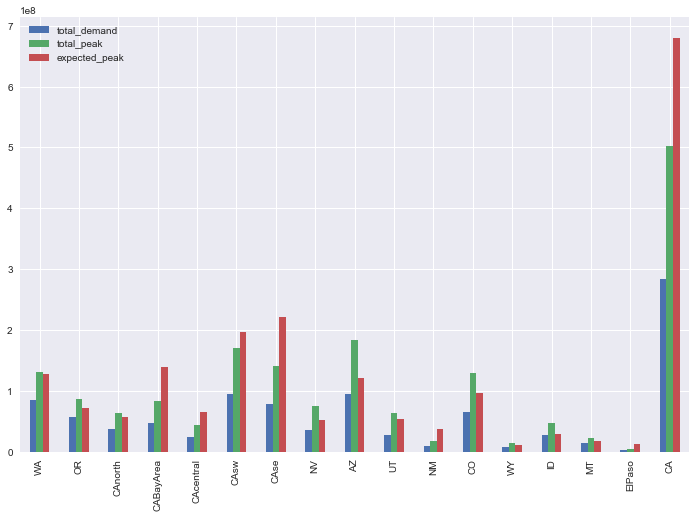

In [38]:
check1.plot.bar(y = ['total_demand', 'total_peak', 'expected_peak'], figsize = (12,8))

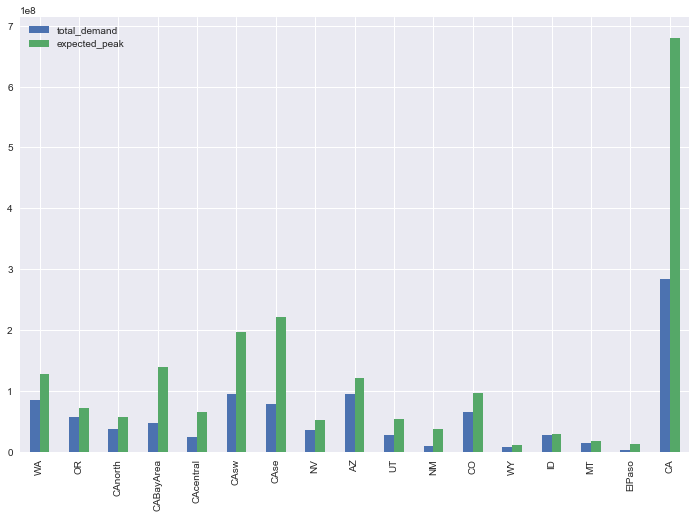

In [39]:
check1.plot.bar(y = ['total_demand', 'expected_peak'], figsize = (12,8))

Calculated demand using BAs is less than expected peak demand using Gegner et al. per capita data

#### Check 2
* EIA/WECC also publishes monthly energy retail data, which is can be proxy for demand; add comparison to those numbers.
* stateElectricityProfiles_2016.txt is obtained by cutting and pasting data from https://www.eia.gov/electricity/state/, then editing the file to remove unnecessary text and remove commas from numbers. The original source is likely in the EIA-860/861 data archives.

In [40]:
stateRetail = pd.read_csv(weccdir + '/' + 'stateElectricityProfiles_2016.txt', sep = '\t', header = 0, index_col= 'Name', 
                          dtype = {'Average retail price (cents/kWh)':'float', 'Net summer capacity (MW)':'float',
                                   'Net generation (MWh)':'float', 'Total retail sales (MWh)':'float'})

In [41]:
stateRetail.head()

,Average retail price (cents/kWh),Net summer capacity (MW),Net generation (MWh),Total retail sales (MWh)
Name,,,,
Alabama,9.56,29077.0,142385098.0,88225141.0
Alaska,17.93,2742.0,6335034.0,6123202.0
Arizona,10.33,28476.0,108763449.0,78237828.0
Arkansas,8.13,14711.0,60445059.0,46188438.0
California,15.23,76537.0,196963215.0,256846635.0


In [42]:
stateDemand = {}
state_names = ['Washington','Oregon','California','Nevada','Arizona','Utah','New Mexico','Colorado','Wyoming','Idaho','Montana']
state_initials = ['WA','OR', 'CA', 'NV', 'AZ','UT', 'NM', 'CO', 'WY', 'ID', 'MT']

for s in zip(state_names, state_initials):
    if s[1] != 'CA':
        stateDemand[s[0]] = demand2016[s[1]].sum()
    else:
        stateDemand['California'] = total_demand['CA']
        
stateDemand_df = pd.DataFrame.from_dict(stateDemand, orient='index', columns = ['total_demand_from_BAs'])

In [43]:
stateDemand_df

,total_demand_from_BAs
Washington,8.412496e+07
Oregon,5.628283e+07
California,2.831168e+08
Nevada,3.643974e+07
Arizona,9.545551e+07
Utah,2.676195e+07
New Mexico,9.679462e+06
Colorado,6.596549e+07
Wyoming,7.537365e+06
Idaho,2.710158e+07


In [44]:
demand_retail = pd.concat([stateDemand_df, stateRetail], axis = 1, join='inner')

In [45]:
demand_retail['demand_retail_ratio'] = demand_retail['total_demand_from_BAs'] / demand_retail['Total retail sales (MWh)']

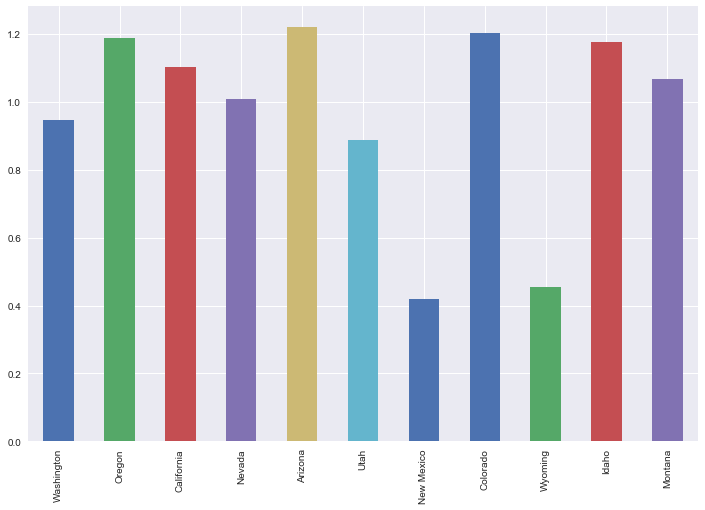

In [46]:
demand_retail['demand_retail_ratio'].plot(kind = 'bar', figsize = [12,8])

* Comparing demand from BA counts against retail sales shows that they are within 20% of each other, except for NM an WY. According to discussion with D. Livengood, WY and NM behavior could be due to overcounting of the BA share in adjacent states. For example, BA PNM is shared between NM and AZ, but only in a small region, but the NM share is significanty decreased because the full AZ population is used in the allocation equation.
* This issue will likely get fixed once we convert BA allocation to using local (e.g., county) level populations instead of using the whole state population.

#### Review missing BA data

* DEAA,GRID, GRIF, GRMA, GWA,HGMA,WWA have missing data

* WA = ['AVA', 'BPAT','CHPD','DOPD','GCPD','PSEI','SCL','TPWR','AVA', 'BPAT']
* OR = ['BPAT','GRID','IPCO','PACW','PGE']
* CAnorth = ['BANC','CISO','PACW','BPAT']
* CABayArea = ['CISO']
* CAcentral = ['CISO', 'TIDC']
* CAsw = ['CISO', 'LDWP']
* CAse = ['CISO', 'IID']
* NV = ['NEVP']
* AZ = ['AZPS','DEAA','GRIF','GRMA','HGMA','PNM','SRP','TEPC','WALC']
* UT = ['PACE']
* NM = ['EPE','PNM']
* CO = ['PSCO','WACM']
* WY = ['PACE','WACM']
* ID = ['AVA','BPAT','IPCO','PACE']
* MT = ['BPAT','GWA','NWMT','WAUW','WWA'] 
* ElPaso = ['EPE']

So
* AZ, OR, MT have unreported demand

But generally, measured demand as calculated is within order of magnitude of peak expected -- may be good enough. 
One thing to check, if possible, is range of demand and population changes over the years and see calculated is within range.

In [47]:
ba2016.columns

Index(['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA', 'DOPD', 'EPE',
       'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID', 'IPCO', 'LDWP',
       'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO', 'PSEI', 'SCL',
       'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW', 'WWA', 'WA',
       'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV', 'AZ',
       'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [48]:
demand2016.columns

Index(['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV',
       'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000196D64CE278>,
      dtype=object)

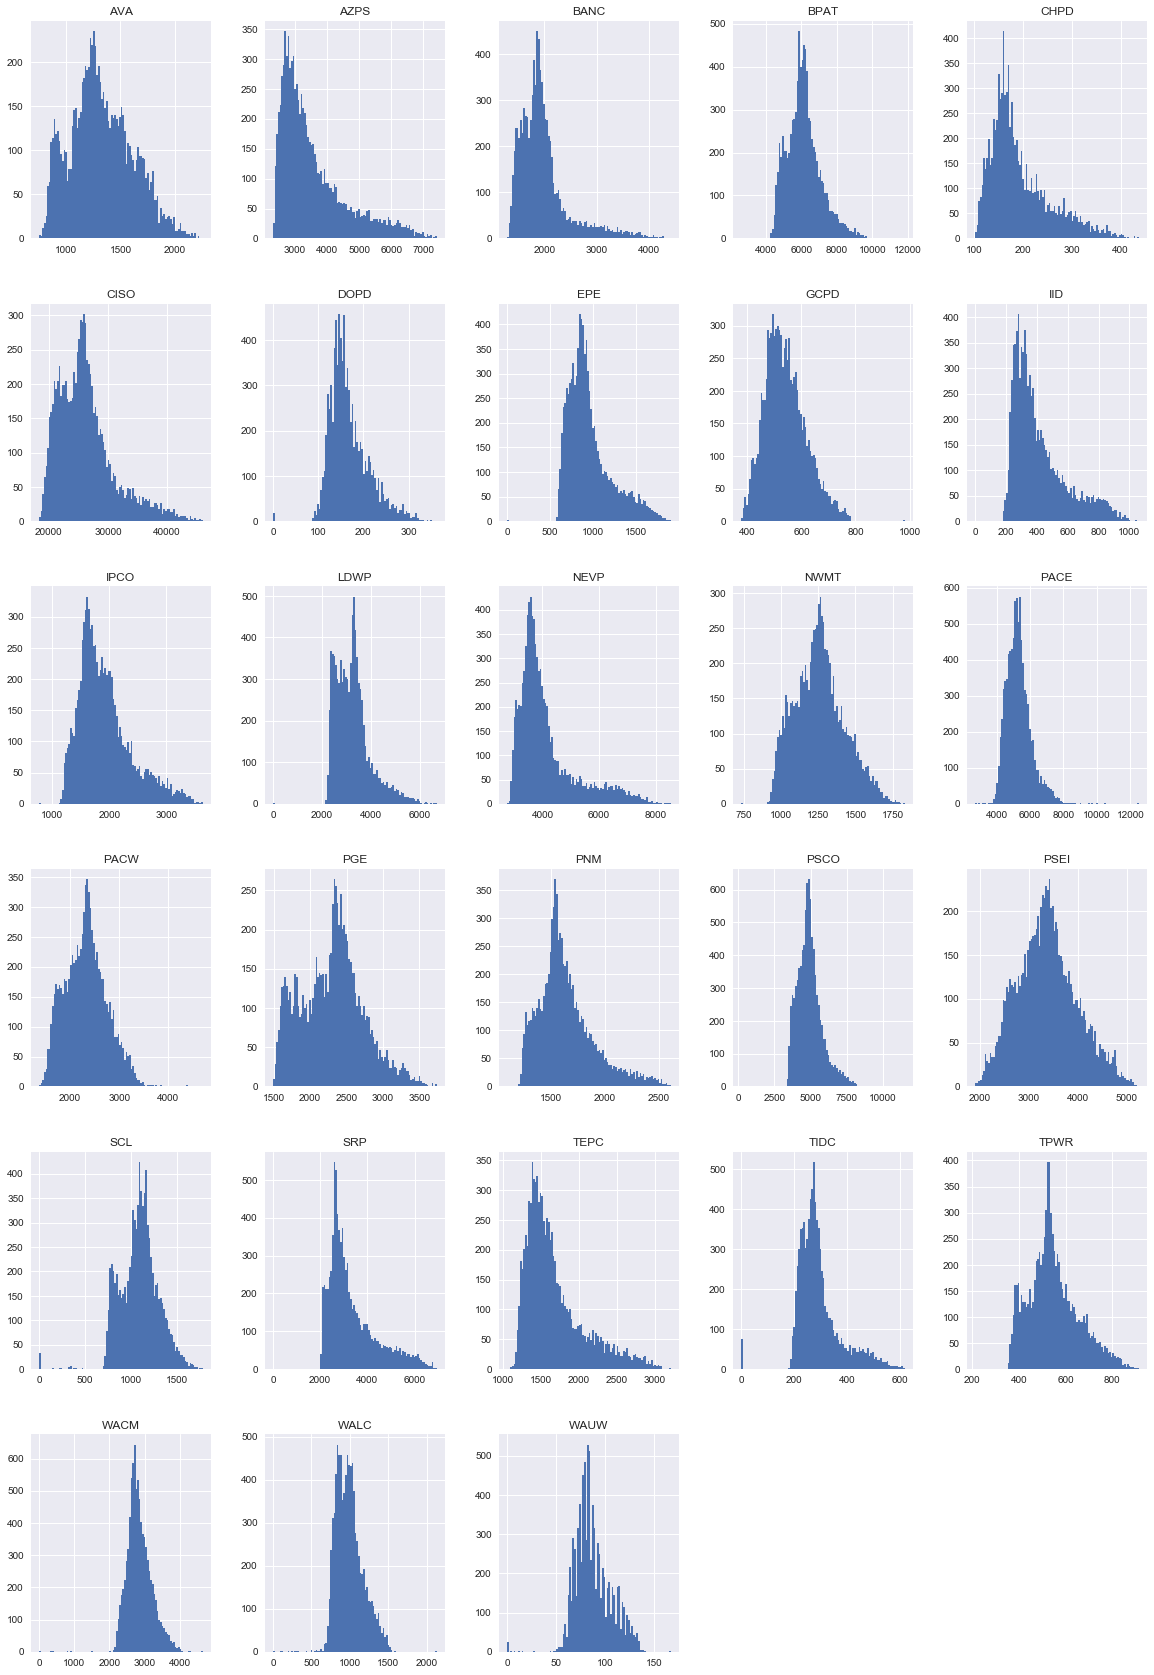

In [49]:
ba2016[['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 
       'DOPD', 'EPE', 'GCPD', 'IID',
       'IPCO', 'LDWP', 'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO',
       'PSEI', 'SCL', 'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW']].hist(bins = 100, figsize = [20,30])

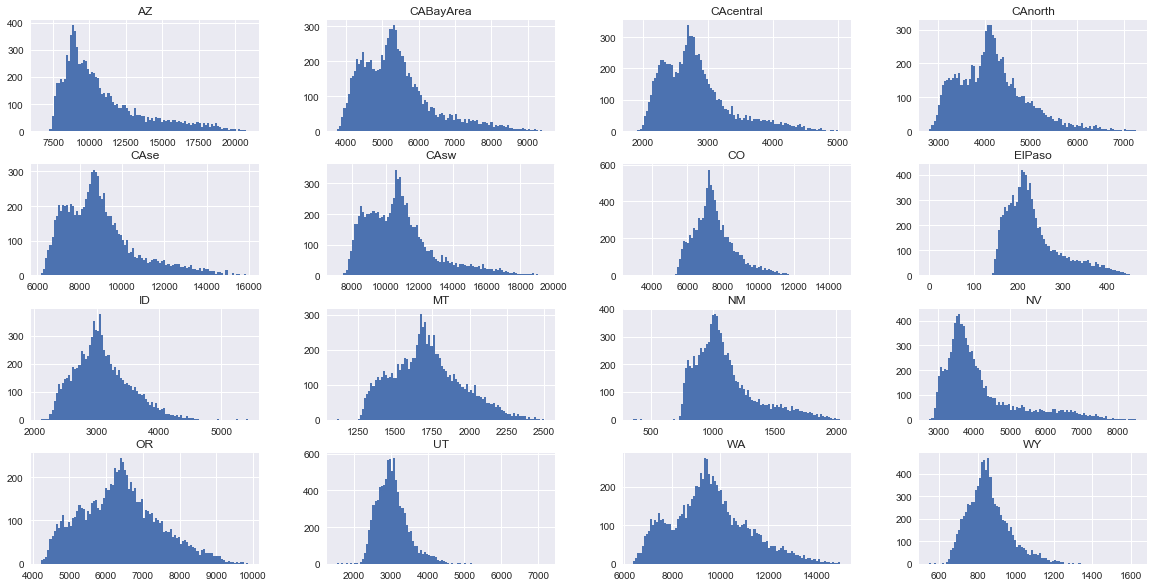

In [50]:
demand_hist = demand2016.hist(bins=100, figsize =[20,10])
plt.savefig('demand_hist.png')

In [51]:
demand2016.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='UTC Time', length=8784, freq=None)

#### Check 3
* Quick check on missing data: does it create discontinuities?
* Recall that current demand profile uses the imputed values from EIA, but EIA only imputes up to 24 hours, so there are hours with missing data.
* BAs with missing data (i.e., no EIA imputed values) are:

|BA| Number of missing hours | Region |
|--|-------------------------|--------|
|DEAA|    8784 |AZ|
|DOPD|      16 |WA|
|GRID|    8784 |OR|
|GRIF|    8784 |AZ|
|GRMA|    8784 |AZ|
|GWA |    8784 |MT|
|HGMA |   8784 |AZ|
|WAUW |     24 |MT|
|WWA  |   8784 |MT|

* Check if DOPD and WAUW missing counts led to discontinuities. It is not expected that those with all-year missing data have discontinuities since there are other BAs in the region that give non-zero counts.


In [52]:
ba2016_wmd = pd.read_csv(weccdir + "/" + 'BA_2016.csv', index_col='UTC Time', parse_dates =True )

In [53]:
ba2016_wmd.head()

,AVA,AZPS,BANC,BPAT,CHPD,CISO,DEAA,DOPD,EPE,GCPD,...,PSEI,SCL,SRP,TEPC,TIDC,TPWR,WACM,WALC,WAUW,WWA
UTC Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1789.0,2982.0,1909.0,7689.0,325.0,23745.0,NaN,256.0,848.0,540.0,...,4238.0,1411.0,2730.0,1624.0,245.0,732.0,3254.0,838.0,108.0,NaN
2016-01-01 01:00:00,1930.0,3363.0,2028.0,8143.0,353.0,24213.0,NaN,282.0,948.0,573.0,...,4712.0,1488.0,3026.0,1801.0,256.0,784.0,3472.0,904.0,123.0,NaN
2016-01-01 02:00:00,1991.0,3642.0,2271.0,8634.0,371.0,25174.0,NaN,298.0,988.0,592.0,...,5085.0,1588.0,3262.0,1788.0,284.0,839.0,3448.0,948.0,110.0,NaN
2016-01-01 03:00:00,1970.0,3615.0,2301.0,8598.0,366.0,28423.0,NaN,293.0,959.0,594.0,...,5030.0,1551.0,3220.0,1763.0,285.0,837.0,3417.0,937.0,115.0,NaN
2016-01-01 04:00:00,1905.0,3568.0,2242.0,8390.0,365.0,28784.0,NaN,294.0,929.0,593.0,...,4845.0,1484.0,3142.0,1739.0,276.0,816.0,3374.0,922.0,112.0,NaN


In [54]:
ba2016_wmd[['DOPD','WAUW']].head()

,DOPD,WAUW
UTC Time,,
2016-01-01 00:00:00,256.0,108.0
2016-01-01 01:00:00,282.0,123.0
2016-01-01 02:00:00,298.0,110.0
2016-01-01 03:00:00,293.0,115.0
2016-01-01 04:00:00,294.0,112.0


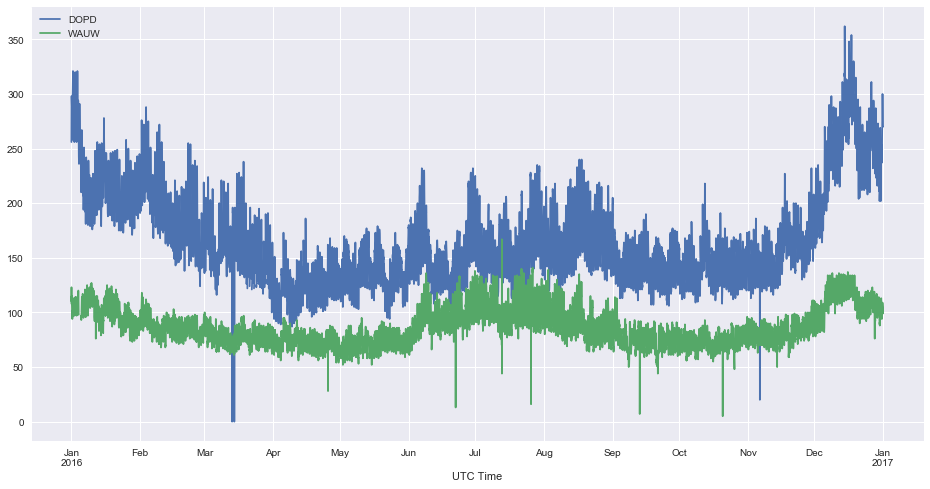

In [55]:
ba2016_wmd[['DOPD','WAUW']].plot(figsize=[16,8])

In [56]:
ba2016_wmd.loc[(ba2016_wmd['DOPD'].isnull()) | (ba2016_wmd['WAUW'].isnull())][['DOPD','WAUW']]

,DOPD,WAUW
UTC Time,,
2016-01-04 08:00:00,243.0,NaN
2016-01-04 09:00:00,238.0,NaN
2016-01-04 10:00:00,236.0,NaN
2016-01-04 11:00:00,241.0,NaN
2016-01-04 12:00:00,244.0,NaN
2016-01-04 13:00:00,249.0,NaN
2016-01-04 14:00:00,267.0,NaN
2016-01-04 15:00:00,287.0,NaN
2016-01-04 16:00:00,291.0,NaN


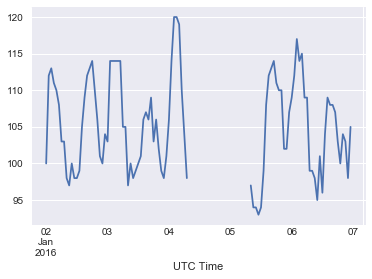

In [57]:
ba2016_wmd.loc['2016-01-02':'2016-01-06']['WAUW'].plot()
# Using previous day's values is reasonable here

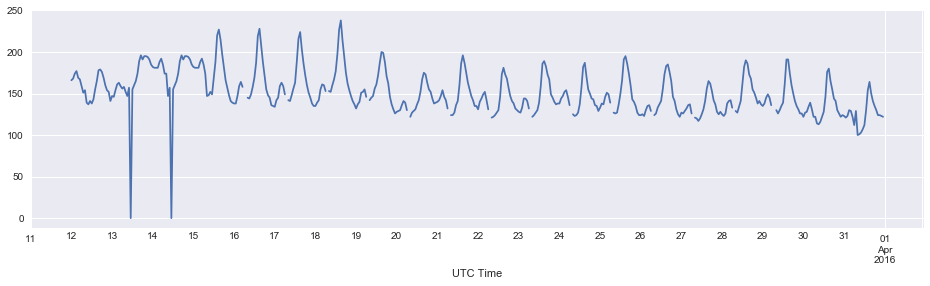

In [58]:
ba2016_wmd.loc['2016-03-12':'2016-03-31']['DOPD'].plot(figsize=[16,4])
#Missing hour is 7:00:00 on 3/16-29
#Why didn't they just impute these? And what happened on 3/13-15  - these are demand= 0 at 11:00 UTC?

In [59]:
ba2016_wmd.loc[ba2016.DOPD == 0]['DOPD']

UTC Time
2016-03-13 11:00:00    0.0
2016-03-14 11:00:00    0.0
2016-03-16 06:00:00    NaN
2016-03-16 07:00:00    NaN
2016-03-17 07:00:00    NaN
2016-03-18 07:00:00    NaN
2016-03-19 07:00:00    NaN
2016-03-20 07:00:00    NaN
2016-03-21 07:00:00    NaN
2016-03-22 07:00:00    NaN
2016-03-23 07:00:00    NaN
2016-03-24 07:00:00    NaN
2016-03-25 07:00:00    NaN
2016-03-26 07:00:00    NaN
2016-03-27 07:00:00    NaN
2016-03-28 07:00:00    NaN
2016-03-29 06:00:00    NaN
2016-03-29 07:00:00    NaN
Name: DOPD, dtype: float64

Do regions with missing BA imputed data show jumpy behavior?

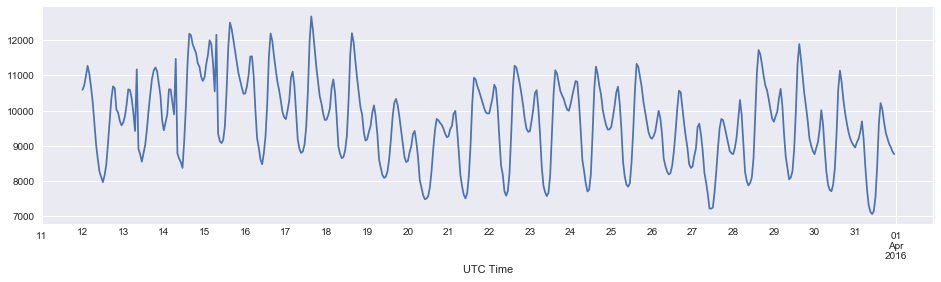

In [60]:
demand2016.loc['2016-03-12':'2016-03-31']['WA'].plot(figsize=[16,4])

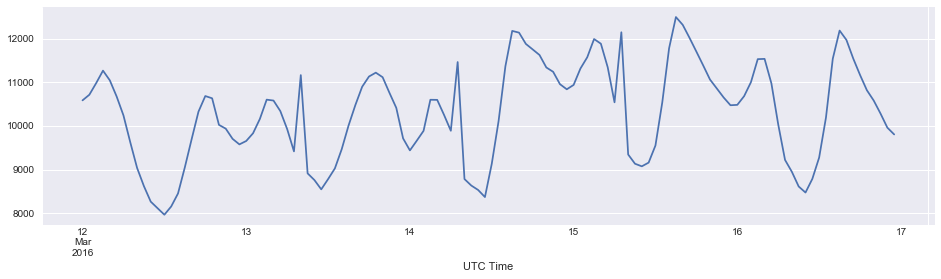

In [61]:
demand2016.loc['2016-03-12':'2016-03-16']['WA'].plot(figsize=[16,4])

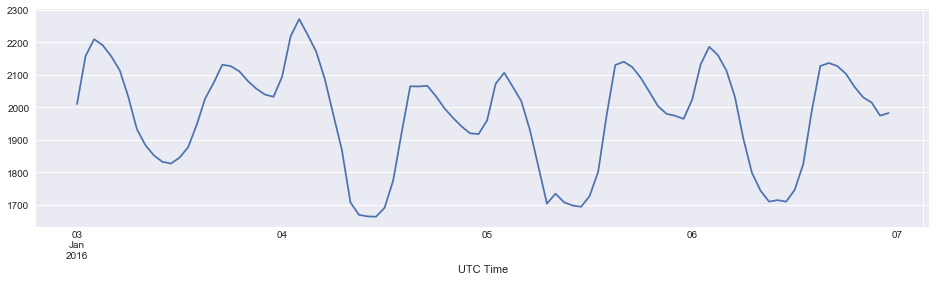

In [62]:
demand2016.loc['2016-01-03':'2016-01-06']['MT'].plot(figsize=[16,4])

In [63]:
ba2016[['DOPD','WAUW','BPAT','NWMT']].describe()

,DOPD,WAUW,BPAT,NWMT
count,8784.000000,8784.000000,8784.000000,8784.000000
mean,168.783470,87.994194,6144.310565,1258.582309
std,43.395499,18.050219,951.664603,166.803180
min,0.000000,0.000000,2600.000000,729.000000
25%,139.000000,76.000000,5501.000000,1138.000000
50%,159.000000,85.000000,6071.000000,1251.000000
75%,191.000000,99.000000,6635.000000,1361.000000
max,362.000000,167.000000,11827.000000,1831.000000


* Answer: The BAs with intermittent missing data (DOPD, WAUW) have relatively low demand counts compared to other BAs in the region (WA, MT respectively), so setting the intermittently missing data to zero at the BA level does not result in glaring spikes in the region data. So for now, we keep version 2.1 of the demand profile. However, keep a record of the hours where these missing data occur for future crosschecking, should simulations result in crashes related to sizes of derivatives.

In [64]:
#To DO: For recording purposes, output the list of UTC Time when these missing, unimputed data occurred.

Check anomaly in CO data: around Dec 22, 2016, there is a big dip in demand. Why is this?

In [66]:
ba2016['PSCO'].mean()

4931.289959016393

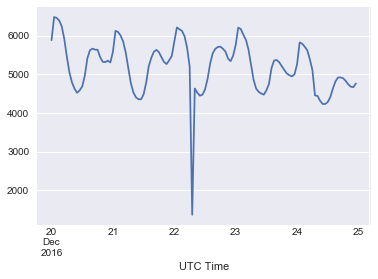

In [71]:
ba2016.loc['2016-12-20':'2016-12-24']['PSCO'].plot()

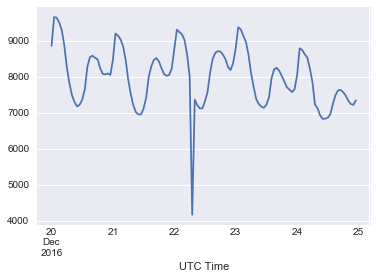

In [72]:
ba2016.loc['2016-12-20':'2016-12-24']['CO'].plot()

In [74]:
ba2016.loc['2016-12-22']['PSCO']

UTC Time
2016-12-22 00:00:00    5852.0
2016-12-22 01:00:00    6219.0
2016-12-22 02:00:00    6172.0
2016-12-22 03:00:00    6130.0
2016-12-22 04:00:00    5991.0
2016-12-22 05:00:00    5692.0
2016-12-22 06:00:00    5205.0
2016-12-22 07:00:00    1363.0
2016-12-22 08:00:00    4637.0
2016-12-22 09:00:00    4527.0
2016-12-22 10:00:00    4450.0
2016-12-22 11:00:00    4476.0
2016-12-22 12:00:00    4610.0
2016-12-22 13:00:00    4883.0
2016-12-22 14:00:00    5278.0
2016-12-22 15:00:00    5547.0
2016-12-22 16:00:00    5662.0
2016-12-22 17:00:00    5712.0
2016-12-22 18:00:00    5722.0
2016-12-22 19:00:00    5667.0
2016-12-22 20:00:00    5593.0
2016-12-22 21:00:00    5414.0
2016-12-22 22:00:00    5344.0
2016-12-22 23:00:00    5487.0
Name: PSCO, dtype: float64

From looking at the Excel spreadsheet from which the data are read (note, a plot from the website also shows this dip: https://www.eia.gov/realtime_grid/#/data/graphs?end=20161224T00&start=20161217T00&bas=00000000000008&regions=0 ), the value does not seem to be an imputed value. However, it is flagged data (there is a number on the 'D Range Error' column). In the future, we can use this error column for flagging potentially anomalous data and imputing a better value. Meanwhile, checking with EIA on their anomalous data policy.

#### Check 4
* Check that for each bus with, the transmission capability of the branches is not violated. 
* To simplify, use the maximum demand assigned to the bus.
* case files are downloaded from